# **Data Cleaning**

## Introduction
In this notebook, we will be cleaning a dataset that contains records of 3 million flights in the United States from 2019 to 2023. The dataset provides valuable information about flight delays and cancellations. 

## Data Source
- [official source](https://www.transtats.bts.gov/)
- [original Dataset](https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023)

The goal of this notebook is to preprocess and clean the dataset to make it suitable for further analysis and visualization.

## 1. Importing necessary packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from skimpy import skim
import os
import matplotlib.pyplot as plt

## 2. Creating the FlightCSVProcessor Class, which Cleans and Downloads the Clean Dataset as CSV

In [2]:
class FlightCSVProcessor:

    # The path to the CSV file to process
    PATH = "flights_sample_3m.csv"

    # Constructor of the class FlightCSVProcessor
    # @param path The path to the CSV file to process
    # @param new_path The path to save the processed CSV file
    def __init__(self, path=PATH, new_path=None):
        print("Loading CSV file...")
        self.df = pd.read_csv(path)
        print("CSV file loaded.")
        self.path = path
        self.new_path = new_path
        self.processed = False

    # modify the name of the columns and drop some columns
    def __compute_columns(self):
        map_columns = {
            'FL_DATE': 'flight_date',
            'AIRLINE_CODE': 'airline_code',
            'ORIGIN': 'origin_airport',
            'ORIGIN_CITY': 'origin_city',
            'DEST': 'destination_airport',
            'DEST_CITY': 'destination_city',
            'CRS_DEP_TIME': 'scheduled_departure_time',
            'DEP_DELAY': 'departure_delay',
            'TAXI_OUT': 'taxi_out',
            'TAXI_IN': 'taxi_in',
            'ARR_DELAY': 'arrival_delay',
            'CANCELLED': 'is_cancelled',
            'CANCELLATION_CODE': 'cancellation_code',
            'AIR_TIME': 'air_time',
            'DISTANCE': 'distance_in_miles',
            'FL_NUMBER': 'flight_number',
            'TAIL_NUMBER': 'tail_number',
            'ELAPSED_TIME': 'elapsed_time',
            'CRS_ARR_TIME': 'scheduled_arrival_time',
            'ACTUAL_ELAPSED_TIME': 'actual_elapsed_time',
            'CRS_DEP_TIME': 'scheduled_departure_time',
            'CRS_ARR_TIME': 'scheduled_arrival_time',
            'CRS_ELAPSED_TIME': 'scheduled_elapsed_time',
            'DIVERTED': 'is_diverted',
            'DISTANCE_GROUP': 'distance_group',
            'ACTUAL_ELAPSED_TIME': 'actual_elapsed_time',
            'AIRLINE_CODE': 'airline_code',
            'AIR_TIME': 'air_time',
            'ARR_DELAY': 'arrival_delay',
            'CANCELLATION_CODE': 'cancellation_code',
            'CANCELLED': 'is_cancelled',
            'CRS_DEP_TIME': 'scheduled_departure_time',
            'DEP_DELAY': 'departure_delay',
            'DEST': 'destination_airport',
            'DEST_CITY': 'destination_city',
            'DISTANCE': 'distance_in_miles',
            'AIRLINE': 'airline_name',
            'ARR_TIME': 'arrival_time',
            'DELAY_DUE_CARRIER': 'delay_due_to_carrier',
            'DELAY_DUE_LATE_AIRCRAFT': 'delay_due_to_late_aircraft',
            'DELAY_DUE_NAS' : 'delay_due_to_national_aviation_system',
            'DELAY_DUE_SECURITY' : 'delay_due_to_security',
            'DELAY_DUE_WEATHER' : 'delay_due_to_weather',
            'DEP_TIME' : 'departure_time',
            'WHEELS_OFF' : 'wheels_off',
            'WHEELS_ON' : 'wheels_on',
        }
        print("Computing columns...")
        df_tmp = self.df.rename(columns=map_columns)
        df_tmp = df_tmp.drop(['AIRLINE_DOT', 'DOT_CODE'], axis=1)
        self.df = df_tmp
        print("Columns computed.")
    
    # fill the NaN values of the delay columns with 0
    def __fillna_delay(self):
        print("Filling NaN values...")
        delay_col = self.df.columns[self.df.columns.str.startswith('delay')].tolist()
        for col in tqdm(delay_col):
            self.df[col] = self.df[col].fillna(0)
        print("NaN values filled.")
    
    # modify the type of the columns
    def __make_type(self):
        print("Making types...")
        self.df['flight_date'] = pd.to_datetime(self.df['flight_date'])
        bool_col = self.df.columns[self.df.columns.str.startswith('is')].tolist()
        for col in tqdm(bool_col):
            self.df[col] = self.df[col].astype(bool)
        self.df['distance_in_miles'] = self.df['distance_in_miles'].astype(int)
        print("Types made.")

    # compute the time columns
    def __compute_time(self):
        print("Computing time...")
        time_cols = self.df.columns[self.df.columns.str.endswith('time')].tolist()
        for rc in ['air_time', 'elapsed_time', 'scheduled_elapsed_time']:
            time_cols.remove(rc)
        time_cols.extend(['wheels_off', 'wheels_on'])
        for col in tqdm(time_cols):
            self.df[col] = self.df[col].fillna(0).astype(int).astype(str).str.zfill(4)
            self.df[col] = pd.to_datetime(self.df[col], format='%H%M', errors='coerce').dt.time
        print("Time computed.")
    
    # compute the duration columns
    def __compute_duration(self):
        print("Computing duration...")
        cols = ['scheduled_elapsed_time', 'elapsed_time', 'air_time', 'arrival_delay', 'departure_delay', 'taxi_in', 'taxi_out', 'delay_due_to_carrier', 'delay_due_to_late_aircraft', 'delay_due_to_national_aviation_system', 'delay_due_to_security', 'delay_due_to_weather', 'delay_due_to_carrier', 'delay_due_to_late_aircraft', 'delay_due_to_national_aviation_system', 'delay_due_to_security']
        for col in tqdm(cols):
            self.df[col] = self.df[col].fillna(0).astype(int)
        print("Duration computed.")
    
    # process the CSV file
    # @param save If True, save the processed CSV file
    def process(self, save=False):
        print("Processing...")
        self.__compute_columns()
        self.__fillna_delay()
        self.__make_type()
        self.__compute_time()
        self.__compute_duration()
        if save:
            if self.new_path is None:
                raise ValueError("You must provide a path to save the file.")
            self.df.to_csv(self.new_path, index=False)  
            print(f"File saved to {self.new_path}.")  
        self.processed = True
        print("Processing done.")

    # display the dataframe
    def display_df(self, n=5):
        return self.df.head(n)   
    
    def compare_file_sizes(self, title1='Original', title2='Cleaned'):
        if self.new_path is None:
            raise ValueError("You must provide a path to save the file.")
        if not self.processed:
            raise ValueError("You must process the csv first.")
        file1_size = os.path.getsize(self.path) / (1024 * 1024)  
        file2_size = os.path.getsize(self.new_path) / (1024 * 1024)  

        plt.scatter([title1, title2], [file1_size, file2_size], s=400, c='blue', alpha=0.5)
        plt.xlabel('File')
        plt.ylabel('Size (MB)')
        plt.title('Comparison of File Sizes')
        plt.show()

In [3]:
flightProc = FlightCSVProcessor(new_path="flights_clean.csv")

Loading CSV file...
CSV file loaded.


## Overview of the Original Dataset

In [54]:
flightProc.display_df(n=3)

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN


In [4]:
flightProc.process()

Processing...
Computing columns...
Columns computed.
Filling NaN values...


  0%|          | 0/5 [00:00<?, ?it/s]

NaN values filled.
Making types...


  0%|          | 0/2 [00:00<?, ?it/s]

Types made.
Computing time...


  0%|          | 0/6 [00:00<?, ?it/s]

Time computed.
Computing duration...


  0%|          | 0/16 [00:00<?, ?it/s]

Duration computed.
Processing done.


# Overview of the Cleaned Dataset

In [56]:
flightProc.display_df(n=3)

,flight_date,airline_name,airline_code,flight_number,origin_airport,origin_city,destination_airport,destination_city,scheduled_departure_time,departure_time,...,is_diverted,scheduled_elapsed_time,elapsed_time,air_time,distance_in_miles,delay_due_to_carrier,delay_due_to_weather,delay_due_to_national_aviation_system,delay_due_to_security,delay_due_to_late_aircraft
0,2019-01-09,United Air Lines Inc.,UA,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",11:55:00,11:51:00,...,False,186,176,153,1065,0,0,0,0,0
1,2022-11-19,Delta Air Lines Inc.,DL,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",21:20:00,21:14:00,...,False,235,236,189,1399,0,0,0,0,0
2,2022-07-22,United Air Lines Inc.,UA,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",09:54:00,10:00:00,...,False,118,112,87,680,0,0,0,0,0


In [57]:
skim(flightProc.df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 3000000 │ │ int64       │ 14    │                                                         │
│ │ Number of columns │ 25      │ │ string      │ 8     │                                                         │
│ └───────────────────┴─────────┘ │ bool        │ 2     │                                                         │
│                                 │ datetime64  │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean    ┃ sd    ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ flight_number             │   0 │      0 │    2500 │  1700 │    1 │  1100 │  2200 │  3800 │  9600 │  ▇▆▃▃  │  │
│ │ departure_delay           │   0 │      0 │     9.9 │    49 │  -90 │    -6 │    -2 │     6 │  3000 │   ▇    │  │
│ │ taxi_out                  │   0 │      0 │      16 │   9.5 │    0 │    11 │    14 │    19 │   180 │   ▇    │  │
│ │ taxi_in                   │   0 │      0 │     7.5 │   6.3 │    0 │     4 │     6 │     9 │   250 │   ▇    │  │
│ │ arrival_delay             │   0 │      0 │     4.1 │    50 │  -96 │   -15 │    -6 │     6 │  2900 │   ▇    │  │
│ │ scheduled_elapsed_time    │   0 │      0 │     140 │    72 │    0 │    90 │   120 │   170 │   700 │  ▇▇▂   │  │
│ │ elapsed_time              │   0 │      0 │     130 │    74 │    0 │    81 │   120 │   170 │   740 │  ▇▆▁   │  │
│ │ air_time                  │   0 │      0 │     110 │    71 │    0 │    59 │    93 │   140 │   690 │  ▇▃▁   │  │
│ │ distance_in_miles         │   0 │      0 │     810 │   590 │   29 │   380 │   650 │  1000 │  5800 │  ▇▂▁   │  │
│ │ delay_due_to_carrier      │   0 │      0 │     4.4 │    32 │    0 │     0 │     0 │     0 │  2900 │   ▇    │  │
│ │ delay_due_to_weather      │   0 │      0 │    0.71 │    14 │    0 │     0 │     0 │     0 │  1700 │   ▇    │  │
│ │ delay_due_to_national_avi │   0 │      0 │     2.3 │    15 │    0 │     0 │     0 │     0 │  1700 │   ▇    │  │
│ │ ation_system              │     │        │         │       │      │       │       │       │       │        │  │
│ │ delay_due_to_security     │   0 │      0 │   0.026 │   1.5 │    0 │     0 │     0 │     0 │  1200 │   ▇    │  │
│ │ delay_due_to_late_aircraf │   0 │      0 │     4.5 │    25 │    0 │     0 │     0 │     0 │  2600 │   ▇    │  │
│ │ t                         │     │        │         │       │      │       │       │       │       │        │  │
│ └───────────────────────────┴─────┴────────┴─────────┴───────┴──────┴───────┴───────┴───────┴───────┴────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ true              ┃ true rate                   ┃ hist               ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━

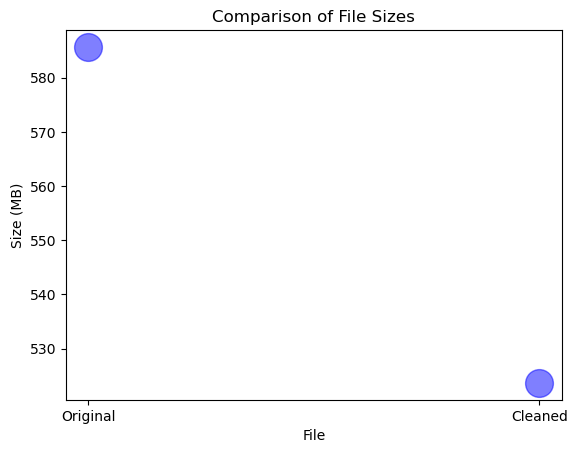

In [59]:
flightProc.compare_file_sizes()

We can notice that thanks to this cleaning, we have saved almost 100 MB of space.

## Next

In this notebook, we have prepared our dataset to visualize it properly. We have renamed the columns, removed unnecessary ones, adjusted the data types of certain columns, and formatted the dates and durations correctly.